In [1]:
from helpers.utilities import *
%run helpers/notebook_setup.ipynb

In [2]:
%R source('plots/colors.R');

In [3]:
%store -r trend_tmm
%store -r trend_rle
%store -r voom_rle
%store -r voom_tmm
%store -r reference_definite_tbm_cm_deg

### Quantification of the similarities and differences

Important reading for filtering limma results using genefilter:
   - https://stat.ethz.ch/pipermail/bioconductor/2012-March/043895.html
   > Clearly filtering should be done before topTable(), because there is no 
point in conducting multiple testing adjustments over probes that are to 
be filtered.

   > Whether to filter before for after eBayes() is not so clear.  I would 
    suggest filtering before, assuming that the probes after filtering are 
    still representative of the whole genome.

   > It makes no difference whether filtering is done before or after lmFit().
   
   - https://stat.ethz.ch/pipermail/bioconductor/2009-October/030062.html
   
   > You are correct that including a bunch of unexpressed genes when 
adjusting for multiplicity will reduce power. However, with limma you 
don't want to remove the 'unexpressed' genes too early (this doesn't 
apply to 'bad' data, where the spots are demonstrably unreliable for 
some reason or another).

   > You have to remember that the eBayes() step adjusts the denominator of 
the t-statistic based on a prior variance estimate that is calculated 
from all the genes under consideration. If you filter out genes prior to 
this step you can bias this estimate.

   > So the recommended method is to perhaps remove demonstrably bad spots 
first, do the normalization, model fitting, etc, and then filter out 
those genes you consider unexpressed before doing the multiplicity 
adjustment.

  - and ofcourse filtering by variance is not advised and wrong for limma: https://support.bioconductor.org/p/59747/

In [4]:
from scipy.stats import spearmanr

In [5]:
def compare_results(a, b, key=None, key_a=None, key_b=None, function=spearmanr, from_quantile=0, up_to_quantile=1, drop_na=True):
    if key:
        key_a = key
        key_b = key
    if key_a:
        a = a[key_a]
    if key_b:
        b = b[key_b]

    a = a.sort_values()
    b = b.sort_values()

    a = a.iloc[int(from_quantile * len(a)):int(up_to_quantile * len(a))]
    b = b.iloc[int(from_quantile * len(b)):int(up_to_quantile * len(b))]
    
    if drop_na:
        a = a.dropna()
        b = b.dropna()

    intersection = list(set(a.index) & set(b.index))

    a_values = a.loc[intersection]
    b_values = b.loc[intersection]
    return function(a_values, b_values)

def get_rank_from_ordered(x):
    return x.reset_index().index

compare_results(trend_tmm, trend_rle, key='P.Value')

SpearmanrResult(correlation=0.9517933981608218, pvalue=0.0)

In [6]:
# should be close to 1
compare_results(trend_tmm, trend_rle, key='logFC').correlation

0.9975381122723402

In [7]:
deseq = reference_definite_tbm_cm_deg.set_index('ensembl_id')

In [8]:
# should be close to 1 as well...
compare_results(trend_tmm, deseq, key_a='logFC', key_b='log2FoldChange').correlation

0.5944694740699201

This one should actually be greater than for TMM...

In [9]:
compare_results(trend_rle, deseq, key_a='logFC', key_b='log2FoldChange').correlation

0.5908762884303742

In [10]:
# this wil be interesting
compare_results(trend_tmm, deseq, key_a='P.Value', key_b='pvalue').correlation

0.23679480941298134

#### Let's dive into rank comparison

I have claimed that the results are comparable when it comes to ordering. Here is the evidence:

Lemma 1: I can use pvalue instead of padj for the non-filtered subset of DESeq2 results:

In [11]:
compare_results(deseq, deseq, key_a='pvalue', key_b='padj', drop_na=True).correlation

0.9999749467709523

And for limma:

In [12]:
compare_results(trend_tmm, trend_tmm, key_a='P.Value', key_b='adj.P.Val').correlation

0.9999997570981566

In [13]:
def calc_rank_correlations(a, b, start=0, step=0.01, end=1, function=spearmanr, window=None, window_start_edge='left', trim=False):
    """
    Use first n (up to given quantile) if no window size ('window') is given, otherwise compute rolling correlation wisth sliding window of given size
    
    Args:
        window_start_edge: 'left' to set the first window as (start, start + window_size),
                           'right' to set the first window as (start - window_size, start)
        trim: if using window, will trim the results so that no results for partial (not fully covering requested size) windows are shown
    """
    
    compare_ab = partial(compare_results, a, b, function=function)
    
    calc_quantile_ranges = (
        (
            
            (lambda q: dict(from_quantile=q, up_to_quantile=q + window))
            if window_start_edge == 'left' else
            (lambda q: dict(from_quantile=max(start, q - window), up_to_quantile=q))
        )
        if window else
        (lambda q: dict(from_quantile=0, up_to_quantile=q))
    )
    
    mode = 'sliding_window' if window else 'up_to_quantile'
    if window:
        mode += '_start' if window_start_edge == 'left' else '_end'
    
    if not window:
        start = start + step
    
    quantiles = np.linspace(start, end, int((end-start)/step))

    return DataFrame([
        {
            'range': '{from_quantile:.2f}:{up_to_quantile:.2f}'.format(**ranges),
            **compare_ab(**ranges)._asdict(),
            **ranges
        }
        for ranges in map(calc_quantile_ranges, quantiles)
        if (
            not trim or
            (window_start_edge == 'left' and ranges['from_quantile'] < end - window) or
            (window_start_edge == 'right' and ranges['up_to_quantile'] > start + window)
        )
    ])

In [14]:
def compare_cumulative_and_sliding(a, b, step=0.001, window=0.1):
    cumulative = calc_rank_correlations(a, b, step=step)
    sliding = calc_rank_correlations(a, b, step=step, window=window, trim=T)

    return concat([
        cumulative.assign(mode='Cumulative - up to n-th quantile'),
        sliding.assign(mode=f'Sliding window of {window}, ending at n-th qunatile')
    ])

In [15]:
fdr_qrc_between_normalizations = compare_cumulative_and_sliding(trend_rle['adj.P.Val'], trend_tmm['adj.P.Val'])

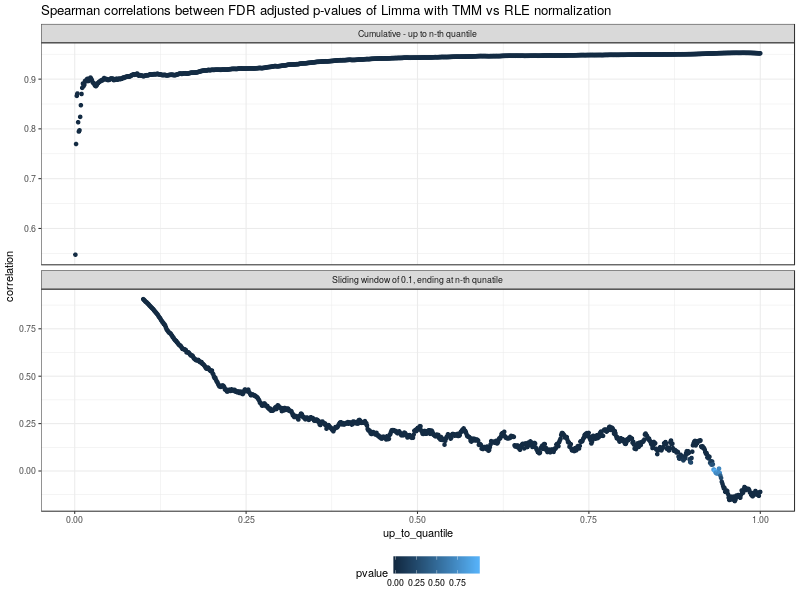

In [16]:
%%R -i fdr_qrc_between_normalizations -w 800 -h 600
(
    ggplot(fdr_qrc_between_normalizations, aes(x=up_to_quantile, y=correlation, color=pvalue))
    + facet_wrap(~mode, ncol=1, scale='free_y')
    + geom_point() + nice_theme + ggtitle('Spearman correlations between FDR adjusted p-values of Limma with TMM vs RLE normalization')
)

In [17]:
fdr_qrc_limma_rle_vs_deseq = compare_cumulative_and_sliding(trend_rle['adj.P.Val'], deseq['padj'])

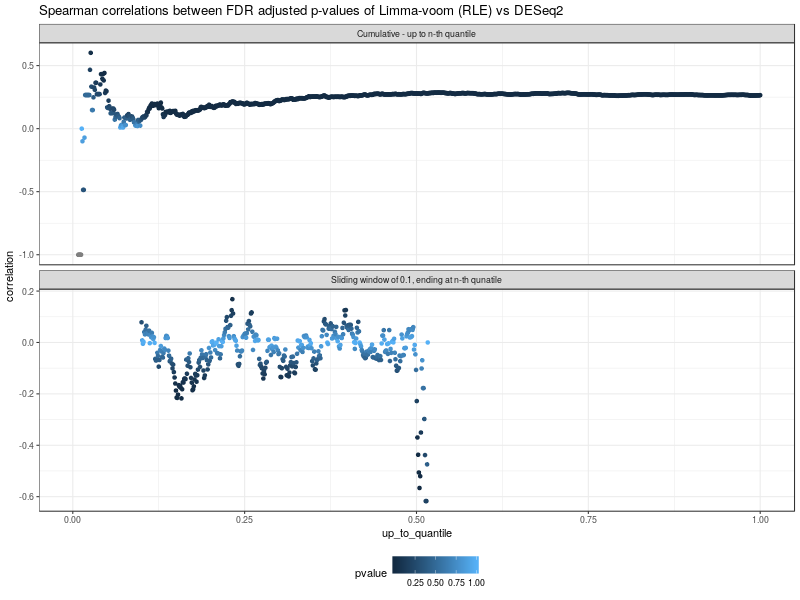

In [18]:
%%R -i fdr_qrc_limma_rle_vs_deseq -w 800 -h 600
(
    ggplot(fdr_qrc_limma_rle_vs_deseq, aes(x=up_to_quantile, y=correlation, color=pvalue))
    + facet_wrap(~mode, ncol=1, scale='free_y')
    + geom_point() + nice_theme + ggtitle('Spearman correlations between FDR adjusted p-values of Limma-voom (RLE) vs DESeq2')
)

The cut in half is the effect of the independent filtering.

In [19]:
pval_qrc_limma_rle_vs_deseq = compare_cumulative_and_sliding(trend_rle['P.Value'], deseq['pvalue'])

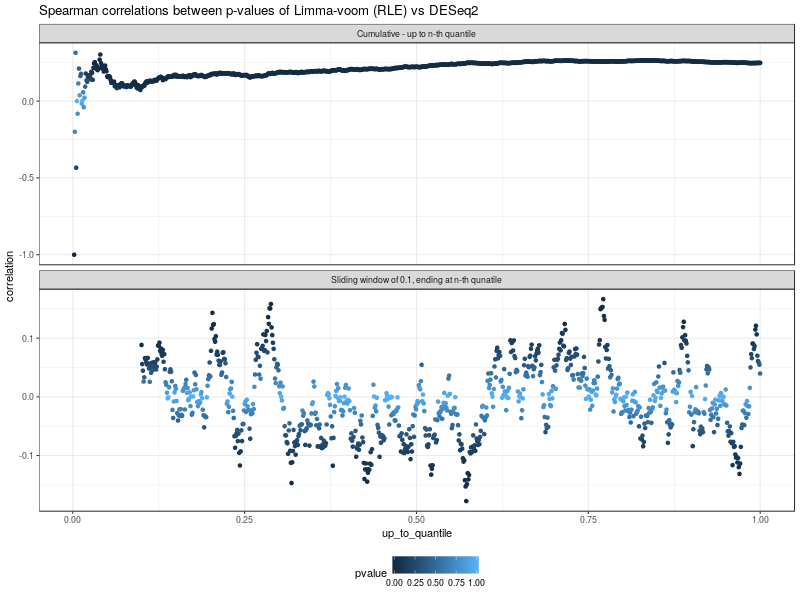

In [20]:
%%R -i pval_qrc_limma_rle_vs_deseq -w 800 -h 600
(
    ggplot(pval_qrc_limma_rle_vs_deseq, aes(x=up_to_quantile, y=correlation, color=pvalue))
    + facet_wrap(~mode, ncol=1, scale='free_y')
    + geom_point() + nice_theme + ggtitle('Spearman correlations between p-values of Limma-voom (RLE) vs DESeq2')
)

In [21]:
compare_results(trend_rle['P.Value'], deseq['pvalue'], up_to_quantile=0.01).correlation

0.03766233766233767

In [22]:
compare_results(trend_rle['P.Value'], deseq['pvalue'], up_to_quantile=0.05).correlation

0.16084583143406672

In [23]:
compare_results(trend_rle['P.Value'], deseq['pvalue'], up_to_quantile=0.1).correlation

0.08841363955176407

- the very first few genes have low correlations, but
- The top 0.01 quantile agrees at a level of r=0.7
- The top 0.05 quantile agrees at a level of r=0.6
- The top 0.1 quantile agrees at a level of r=0.4
- overall the agreement is at a Spearman correlation of 0.5

## What about the DESeq2 with variance stabilization?

as suggested here: https://support.bioconductor.org/p/52228/

### Sanity check: reproducibility of the preliminary DESeq2 results

In [24]:
%store -r by_condition_and_tb_subset
%store -r reference_samples
%store -r raw_counts_trimmed

In [25]:
%%R -i reference_samples -i raw_counts_trimmed -i by_condition_and_tb_subset
# raw_counts_matrix_no_outliers, by_condition_and_tb_subset_no_outliers
conditions_for_deseq = by_condition_and_tb_subset[reference_samples, drop=F]

colnames(raw_counts_trimmed) = colnames(by_condition_and_tb_subset)
#print(by_condition_and_tb_subset)

dds <- DESeq2::DESeqDataSetFromMatrix(
    countData = round(raw_counts_trimmed),
    colData = as.data.frame(conditions_for_deseq),
    design = ~ conditions_for_deseq
)

keep <- rowSums(DESeq2::counts(dds)) >= 10
dds <- dds[keep,]

dds <- DESeq2::DESeq(dds)

In [26]:
%%R -o my_deseq2
my_deseq2 = as.data.frame(
    DESeq2::results(dds, contrast=c('conditions_for_deseq', 'Definite tuberculosis', 'Cryptococcal'))
)

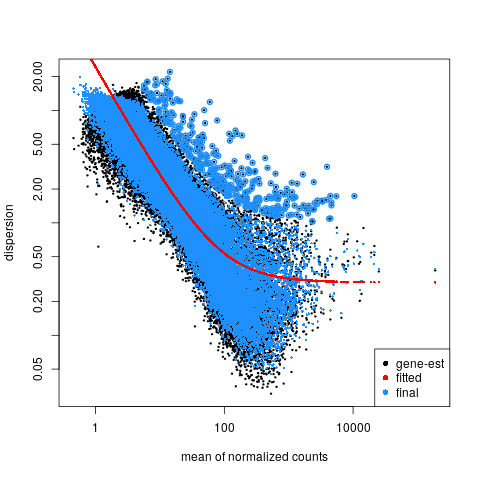

In [41]:
%%R
DESeq2::plotDispEsts(dds)

In [42]:
my_deseq2 = my_deseq2.sort_values('padj')

In [43]:
assert not set(deseq.index) - set(my_deseq2.index)

There are many more genes in my results:

In [44]:
my_deseq2.loc[deseq.index]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ensembl_id,,,,,,
ENSG00000100226,554.310964,1.168374,0.217316,5.376390,7.599392e-08,0.000261
ENSG00000165997,204.213134,1.929981,0.420836,4.586070,4.516680e-06,0.001871
ENSG00000164691,896.635085,1.938904,0.400073,4.846379,1.257355e-06,0.001871
ENSG00000108771,119.662961,1.787080,0.366065,4.881864,1.050878e-06,NaN
ENSG00000128016,1919.092549,1.654465,0.349026,4.740233,2.134721e-06,0.001871
...,...,...,...,...,...,...
ENSG00000179041,60.938375,-0.019390,0.355825,-0.054494,9.565416e-01,NaN
ENSG00000188582,27.673357,0.061704,0.842532,0.073237,9.416177e-01,NaN
ENSG00000092470,53.917390,-0.012513,0.371368,-0.033693,9.731216e-01,NaN


But overall, the p-values (for these genes that overlap) are highly correlated:

In [45]:
compare_results(deseq['pvalue'], my_deseq2['pvalue'])

SpearmanrResult(correlation=0.9836716216175546, pvalue=0.0)

In [46]:
pval_qrc_deseq_reproducibility = compare_cumulative_and_sliding(deseq['pvalue'], my_deseq2['pvalue'])

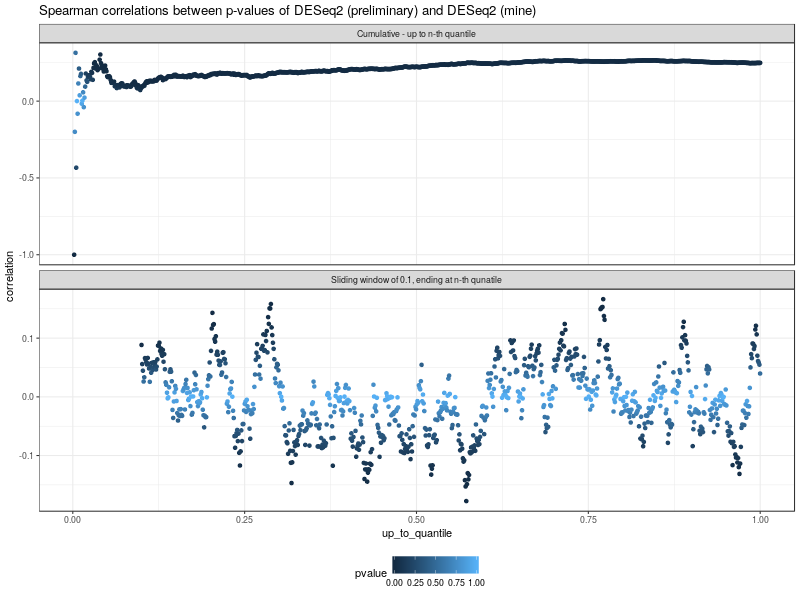

In [47]:
%%R -i pval_qrc_deseq_reproducibility -w 800 -h 600
(
    ggplot(pval_qrc_limma_rle_vs_deseq, aes(x=up_to_quantile, y=correlation, color=pvalue))
    + facet_wrap(~mode, ncol=1, scale='free_y')
    + geom_point() + nice_theme + ggtitle('Spearman correlations between p-values of DESeq2 (preliminary) and DESeq2 (mine)')
)

### The variance stabilization with log-transformation

In [48]:
%%R
# raw_counts_matrix_no_outliers, by_condition_and_tb_subset_no_outliers
conditions_for_deseq = by_condition_and_tb_subset[reference_samples, drop=F]

dds <- DESeq2::DESeqDataSetFromMatrix(
    countData = round(raw_counts_trimmed),
    colData = as.data.frame(conditions_for_deseq),
    design = ~ conditions_for_deseq
)

keep <- rowSums(DESeq2::counts(dds)) >= 10
dds <- dds[keep,]
mean(keep)

[1] 1


In [49]:
%%R
dds$conditions_for_deseq <- relevel(factor(dds$conditions_for_deseq), ref = "Cryptococcal")

In [50]:
%%R
dds <- DESeq2::DESeq(dds)

In [51]:
%%R -o my_deseq2
my_deseq2 = as.data.frame(
    DESeq2::results(dds, contrast=c('conditions_for_deseq', 'Definite tuberculosis', 'Cryptococcal'))
)

Reproducibility of p-values is high:

In [52]:
compare_results(deseq['pvalue'], my_deseq2['pvalue'])

SpearmanrResult(correlation=0.9836714076725703, pvalue=0.0)

But the dimensions differ and there are some nulls in my results:

In [53]:
deseq.shape, my_deseq2.shape

((21488, 8), (38664, 6))

In [54]:
outliers = my_deseq2[my_deseq2.pvalue.isnull()]
print(len(outliers))
outliers.head()

227


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSG00000075886,11.136301,0.070020,0.911042,0.076857,NaN,NaN
ENSG00000111245,3.607323,-0.728389,1.435122,-0.507545,NaN,NaN
ENSG00000121211,1.205116,-0.226327,2.042517,-0.110808,NaN,NaN
ENSG00000138472,2.239779,-2.252845,1.604089,-1.404439,NaN,NaN
ENSG00000164687,76.430587,-0.163094,0.527262,-0.309323,NaN,NaN


> If a row contains a sample with an extreme count outlier then the p value and adjusted p value will be set to NA. These outlier counts are detected by Cook’s distance. Customization of this outlier filtering and description of functionality for replacement of outlier counts and refitting is described below 
(https://www.bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#more-information-on-results-columns)

In [55]:
assert not outliers.baseMean.isnull().any()

In [56]:
assert not deseq.pvalue.isnull().any()

A few outliers made it into the preliminary results:

In [57]:
deseq[deseq.index.isin(outliers.index)]

,ensembl_gene_name,description,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ensembl_id,,,,,,,,
ENSG00000211899,IGHM,immunoglobulin heavy constant mu,1677.185923,0.576234,0.625783,0.920821,0.357144,0.827582
ENSG00000164687,FABP5,fatty acid binding protein 5,63.672165,-0.152331,0.376654,-0.404432,0.685895,0.953157
ENSG00000211947,IGHV3-21,immunoglobulin heavy variable 3-21,40.103035,-0.142102,0.775797,-0.183170,0.854665,NaN
ENSG00000075886,TUBA3D,tubulin alpha 3d,10.866738,0.087869,0.813550,0.108007,0.913990,NaN


In [58]:
deseq2_without_outliers = my_deseq2[~my_deseq2.pvalue.isnull()]

### With pre-selected samples?

In [59]:
%%R
conditions_for_deseq = by_condition_and_tb_subset[reference_samples, drop=F]
conditions_subset = conditions_for_deseq %in% c('Definite tuberculosis', 'Cryptococcal')

conditions_for_deseq = conditions_for_deseq[conditions_subset]

dds <- DESeq2::DESeqDataSetFromMatrix(
    countData = round(raw_counts_trimmed[,conditions_subset]),
    colData = as.data.frame(conditions_for_deseq),
    design = ~ conditions_for_deseq
)

keep <- rowSums(DESeq2::counts(dds)) >= 10
dds <- dds[keep,]
mean(keep)

[1] 0.9997931


In [60]:
%%R
dds$conditions_for_deseq <- relevel(factor(dds$conditions_for_deseq), ref = "Cryptococcal")

In [61]:
%%R
dds <- DESeq2::DESeq(dds)

In [62]:
%%R -o deseq_preselected
deseq_preselected = as.data.frame(
    DESeq2::results(dds, contrast=c('conditions_for_deseq', 'Definite tuberculosis', 'Cryptococcal'))
)

In [63]:
compare_results(deseq['pvalue'], deseq_preselected['pvalue']).correlation - compare_results(deseq['pvalue'], my_deseq2['pvalue']).correlation

0.006146441264969882

In [64]:
deseq_preselected.sort_values('pvalue')

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSG00000100226,508.880103,1.186088e+00,0.235406,5.038477,4.692510e-07,0.000520
ENSG00000224789,5.906849,6.025104e+00,1.201473,5.014765,5.309819e-07,NaN
ENSG00000115956,2235.144885,2.074911e+00,0.414511,5.005688,5.566291e-07,0.000520
ENSG00000131979,287.302474,1.863033e+00,0.372482,5.001669,5.683619e-07,0.000520
ENSG00000164691,953.541896,1.950295e+00,0.393124,4.961017,7.012503e-07,0.000520
...,...,...,...,...,...,...
ENSG00000228002,22.030677,1.830359e-04,0.776791,0.000236,9.998120e-01,NaN
ENSG00000204241,30.688374,9.848408e-05,0.615829,0.000160,9.998724e-01,NaN
ENSG00000259462,37.267193,7.172149e-05,0.612015,0.000117,9.999065e-01,NaN
ENSG00000118515,281.528140,-9.942978e-06,0.438997,-0.000023,9.999819e-01,0.999982


In [65]:
deseq_preselected.pvalue

ENSG00000000003    0.609716
ENSG00000000005    0.508720
ENSG00000000419    0.755469
ENSG00000000457    0.099687
ENSG00000000460    0.914402
                     ...   
ENSG00000284543    0.114514
ENSG00000284546    0.146290
ENSG00000284552    0.466725
ENSG00000284572    0.152918
ENSG00000284600    0.176369
Name: pvalue, Length: 38656, dtype: float64

In [66]:
sum(deseq_preselected.pvalue.isnull())

0

if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("apeglm")

### Effect of shrinkage method

In [67]:
%%R -o ashr -o normal
definit_tbm_vs_crypto_contrast = c('conditions_for_deseq', 'Definite tuberculosis', 'Cryptococcal')
ashr <- as.data.frame(DESeq2::lfcShrink(dds, contrast=definit_tbm_vs_crypto_contrast, type="ashr"))
normal <- as.data.frame(DESeq2::lfcShrink(dds, contrast=definit_tbm_vs_crypto_contrast, type="normal"))

In [68]:
%%R -o apeglm
apeglm <- as.data.frame(DESeq2::lfcShrink(dds, coef='conditions_for_deseq_Definite.tuberculosis_vs_Cryptococcal', type="apeglm"))

In [69]:
compare_results(deseq['pvalue'], normal['pvalue'])

SpearmanrResult(correlation=0.9898178489375402, pvalue=0.0)

In [70]:
compare_results(deseq['pvalue'], ashr['pvalue'])

SpearmanrResult(correlation=0.9898178489375402, pvalue=0.0)

In [71]:
compare_results(deseq['pvalue'], apeglm['pvalue'])

SpearmanrResult(correlation=0.9898178489375402, pvalue=0.0)

In [72]:
compare_results(trend_rle['P.Value'], ashr['pvalue'])

SpearmanrResult(correlation=0.2999683812112374, pvalue=0.0)

In [73]:
compare_results(trend_rle['P.Value'], apeglm['pvalue'])

SpearmanrResult(correlation=0.2999683812112374, pvalue=0.0)

In [74]:
compare_results(trend_rle['P.Value'], deseq['pvalue'])

SpearmanrResult(correlation=0.24888946624452693, pvalue=1.4589627444068235e-300)

In [75]:
shrinkages = {'apeglm': apeglm, 'normal': normal, 'ashr': ashr}

Different shrinkage algorithms change the final log fold change visibly:

In [76]:
lfc_by_shrinkage = concat([
    table[['log2FoldChange']].assign(shrinkage=name)
    for name, table in shrinkages.items()
]).rename_axis('gene').reset_index()

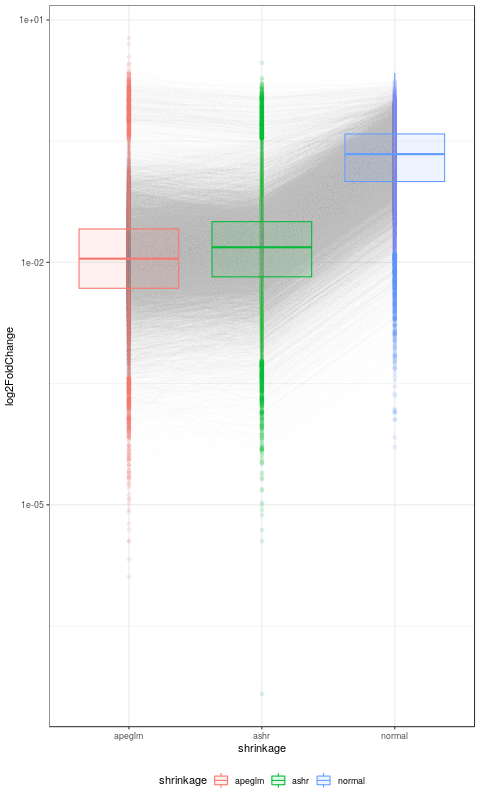

In [77]:
%%R -i lfc_by_shrinkage -h 800
(
    ggplot(lfc_by_shrinkage, aes(x=shrinkage, y=log2FoldChange, fill=shrinkage, color=shrinkage))
    + nice_theme
    + geom_point(alpha=0.01)
    + geom_line(aes(group=gene), color='grey', alpha=0.01)
    + geom_boxplot(alpha=0.1)
    + scale_y_log10()
)

But it does not influence the number or composition of genes marked as significant:

In [1]:
from helpers.venn import venn3

In [78]:
venn3({
    name: set(table.query('padj < 0.05').index)
    for name, table in shrinkages.items()
});

NameError: name 'venn3' is not defined

In [ ]:
len(deseq.query('padj < 0.05'))

### Reproducing the adjusted p-value calculation

Works easily for limma, this is simple BH FDR:

In [ ]:
%%R -o fdr_trend_rle
fdr_trend_rle = p.adjust(trend_rle$P.Value, 'BH')
head(fdr_trend_rle)

In [ ]:
assert np.isclose(trend_rle['adj.P.Val'], fdr_trend_rle).all()

For DESeq2: this is not as easy (as it uses independent filtering):

In [ ]:
%%R -o fdr_deseq2 -o deseq2_order
deseq2_order <- normal[order(normal$pvalue),]
fdr_deseq2 = p.adjust(deseq2_order$pvalue, 'BH')
head(fdr_deseq2)

In [ ]:
np.isclose(deseq2_order['padj'], fdr_deseq2).all()

But if we used simple FDR, the number of significant genes would still be much higher in DESeq2:

In [ ]:
%R (sum(fdr_deseq2 < 0.05, na.rm=T))

Still, the independent filtering must have an important impact on the result! But why I did not see such impact when filtering limma results? Let's try to reproduce from both sides:

In [ ]:
%%R -w 800
par(mfrow=c(1, 2))
filter_by_mean_expresion(trend_rle); title('limma-trend RLE')
filter_by_mean_expresion(normal, expression_col='baseMean', pvalue_col='pvalue'); title('DESeq2')

This does not seem to be due to differences in mean expression calculation:

In [ ]:
deseq_vs_limma_mean = compare_cumulative_and_sliding(trend_rle['AveExpr'], my_deseq2['baseMean'])

In [ ]:
%%R -i deseq_vs_limma_mean -w 800 -h 600
(
    ggplot(deseq_vs_limma_mean, aes(x=up_to_quantile, y=correlation, color=pvalue))
    + facet_wrap(~mode, ncol=1, scale='free_y')
    + geom_point() + nice_theme + ggtitle('Spearman correlations between base/mean expression of Limma-voom (RLE) vs DESeq2')
)

In [ ]:
import random
random.seed(0)

trend_rle_random_200 = trend_rle.sample(n=200)

mean_by_method = concat([
    trend_rle_random_200[['AveExpr']].assign(method='limma-trend RLE'),
    my_deseq2[['baseMean']].loc[trend_rle_random_200.index].rename(columns={'baseMean': 'AveExpr'}).assign(method='DESeq2')
])

In [ ]:
%%R -i mean_by_method -h 800
(
    ggpubr::ggpaired(
        mean_by_method, x='method', y='AveExpr',
        color='method', line.color='gray', xlab='Method'
    )
    + scale_y_log10()
)

#### Using the DESeq2-calculated mean for filtering:

In [ ]:
trend_rle['mean_count_expr'] = my_deseq2['baseMean'].loc[trend_rle.index]

In [ ]:
subset_trend_rle = trend_rle[
    (~trend_rle.mean_count_expr.isnull())
    &
    trend_rle.index.isin(deseq2_without_outliers.index)
]

In [ ]:
%%R -i subset_trend_rle
filter_by_mean_expresion(subset_trend_rle, expression_col='mean_count_expr')

Changes the result slightly (one DE gene more).

### Comparing raw p-values:

So it's on on the raw p-values again...

In [ ]:
p_value_comparison = concat([
    subset_trend_rle[['P.Value']].rename({'P.Value': 'pvalue'}, axis=1).assign(method='limma-RLE'),
    deseq2_without_outliers.loc[subset_trend_rle.index][['pvalue']].assign(method='DESeq2'),
]).rename_axis('gene').reset_index()

In [ ]:
%%R -i p_value_comparison
(
    ggplot(p_value_comparison, aes(x=log10(pvalue), fill=method, color=method))
    + nice_theme
    + geom_density(data=p_value_comparison[p_value_comparison$method=='DESeq2',], alpha=0.2)
    + geom_density(data=p_value_comparison[p_value_comparison$method=='limma-RLE',], alpha=0.2)
    + scale_y_sqrt()
)

In [ ]:
%%R -i p_value_comparison -w 800
(
    ggplot(p_value_comparison, aes(x=log10(pvalue), fill=method))
    + geom_histogram()
    + facet_wrap(~ method)
    + scale_y_log10()
    + stat_bin(aes(y=..count.., label=..count..), geom="text", vjust=-.5)
    + nice_theme
)

In [ ]:
%%R -i p_value_comparison -w 800

up_to_m4 = p_value_comparison[p_value_comparison$pvalue<0.5*10e-4,]
up_to_m4$method = as.factor(up_to_m4$method)

(
    ggpubr::ggpaired(
        up_to_m4, x='method', y='-pvalue',
        color='method', line.color='gray', xlab='Method'
    )
    + scale_x_discrete(breaks=up_to_m4$method)
)

> "In DESeq2 the p-value is from a test that the absolute value of the LFC is greater than 2, while in edgeR the p-value is from a test that the absolute value of the LFC is greater than 0. For comparison can you try" prof Mike Love [at seqanswers](http://seqanswers.com/forums/showthread.php?t=49495)

### Gene sets

Let's compare gene sets:

In [ ]:
%R calc_de_tb_subsets('Definite tuberculosis', 'Cryptococcal', camera=T)

In [ ]:
%%R -i reference_definite_tbm_cm_deg
reference_definite_tbm_cm_deg = reference_definite_tbm_cm_deg[complete.cases(enembl_to_entrez[reference_definite_tbm_cm_deg$ensembl_id,]),]
rownames(reference_definite_tbm_cm_deg) = enembl_to_entrez[reference_definite_tbm_cm_deg$ensembl_id,]

In [ ]:
%R limma::cameraPR(setNames(reference_definite_tbm_cm_deg$stat, rownames(reference_definite_tbm_cm_deg)), collection)

In [ ]:
%R limma::cameraPR(setNames(reference_definite_tbm_cm_deg$log2FoldChange, rownames(reference_definite_tbm_cm_deg)), collection)

In [ ]:
top_reference.map(get_gene).map(lambda gene: gene.name)

In [ ]:
list(top_limma.map(get_gene).map(lambda gene: gene.name))

In [ ]:
%R source('plots/volcano.R');

In [ ]:
%%R
c_definite_tb_cm$protein = rownames(c_definite_tb_cm)
volcano_plot(c_definite_tb_cm)

I do not like this plot... It should not look like that...

- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4927907/ [Parkinson's] used EdgeR (likely the default - TMM)
- https://www.biorxiv.org/content/biorxiv/early/2018/12/07/490045.full.pdf [pneumococcal meningitis IL-17] used DESeq2 (probably RLE); they have beautiful volcano plots but that's cause they have survivors vs non-survivors; this study is thus free of this problem

okey, I cannot quickly find comparable study with a statistician engaged in the data processing...

Literature:

> Different studies (e.g., [44, 61]) indicated TMM and ‘DESeq’ methods as the most effective approaches for library size normalization. However, if the common assumption that the compared samples contain similar amount of RNA does not hold, count normalization methods are ineffective, and calibration techniques leveraging on spike-in RNA measurements can be used [63]. [(Finotello and Camillo, 2014)](https://academic.oup.com/bfg/article/14/2/130/257370)

Well we don't have synthetic spike-in RNAs, do we?


We probably cannot relay on the housekeping genes neither...


Do we have some genes that must be there? Like genes which are always present in meningitis?

[(Otake et al, 2019)](https://bmcmedgenomics.biomedcentral.com/articles/10.1186/s12920-019-0473-z) used DESeq2 for exosomal RNASeq in CSF (healthy vs amyotrophic lateral sclerosis, ALS) and found some of the same issues:

> Based on the hypothesis that disease conditions in ALS would be different from healthy conditions, we did not exclude the uncommon genes in NH group in the following DESeq2 analysis. In false discovery rate (FDR) correction by Benjamini-Hochberg method, 5006 genes could be calculated for adjusted p-values (data not shown, see Additional file 3). Thus, the genes with no detection in any specimens or with outliers in some specimens were not calculated for adjusted p-values. DESeq2 analysis resulted in 543 genes that were significantly changed between NH donors and ALS patients groups, with adjusted p-values less than 0.05 (Fig. 4a).

    
> There existed two limitations in this study. One is low statistical power due to small sample size. It was considered as a main reason why so many genes were determined as DEGs. In DESeq2, FDR correction can be applied to the genes without no outlier identified cook’s distance. Small sample size might not be enough to identify true outliers. The other is extremely low abundance of exosomal mRNAs that might cause the large variation of gene expression among four NH specimens

(I disagree with their reasoning on the FDR)

> We reported that more than 4500 genes were commonly detected in exosomes in CSF from NH donors, and also showed that housekeeping genes such as ACTB and GAPDH in the exosomes were also abundant and consistent among four individuals. DESeq2 can be applied to RNA-seq with normalization by logarithm of geometric mean of all genes. Upon further validation in RT-PCR, how the data is normalized should be considered because there is no information in housekeeping genes in exosomes


In [ ]:
from jupyter_helpers.notifications import Notifications

Notifications(success_audio='/usr/share/sounds/gnome/default/alerts/bark.ogg', time_threshold=2);